In [1]:
import tensorflow as tf
from tensorflow import math as tfm

from reggae.data_loaders import load_barenco_puma, DataHolder
from gpflow.conditionals.util import sample_mvn
from gpflow.conditionals import base_conditional
from gpflow.kernels import SquaredExponential
from gpflow import Parameter
from gpflow.utilities import positive

from matplotlib import pyplot as plt

import tensorflow_probability as tfp
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
f64 = np.float64
#was tf 2.3.1 and tfp 0.11.1

In [2]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = m_observed
f_observed = f_observed
data = (m_observed, f_observed)

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre)
noise_data = (σ2_m_pre, σ2_f_pre)

print(m_observed.shape)
display(m_df)
num_genes = m_observed.shape[1]
num_tfs = f_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
t_start = f64(0)
t_end = f64(1)
t = tf.reshape(tf.linspace(t_start, t_end, granularity), (-1, 1))
t_inducing = tf.reshape(tf.linspace(t_start, t_end, 7), (-1, 1))
print(t.shape)

(3, 5, 7)
(100, 1)


,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL,cARP2-0hrs.CEL,cARP2-2hrs.CEL,cARP2-4hrs.CEL,...,cARP2-8hrs.CEL,cARP2-10hrs.CEL,cARP2-12hrs.CEL,cARP3-0hrs.CEL,cARP3-2hrs.CEL,cARP3-4hrs.CEL,cARP3-6hrs.CEL,cARP3-8hrs.CEL,cARP3-10hrs.CEL,cARP3-12hrs.CEL
DDB2,7.593549,9.122439,10.192915,10.154778,10.103455,9.529804,9.567770,7.464445,8.611248,9.255834,...,8.149388,9.367364,9.342251,7.353484,7.665469,9.798868,9.345199,8.757635,8.357981,9.026733
BIK,2.905667,6.756250,8.154665,8.222898,8.074595,7.026262,7.001658,4.649182,5.926949,7.346142,...,4.659069,6.772798,7.005289,5.204797,4.139740,8.056000,7.122196,5.633847,4.488936,5.724764
TNFRSF10b,3.949437,7.283147,8.395333,8.147465,8.456766,7.370946,7.409659,3.828976,6.362601,7.576429,...,5.897853,6.975229,7.280981,4.822874,5.389953,7.749164,7.387181,6.083331,6.024036,6.771154
p21,1.268160,7.375613,9.600847,8.485615,8.134573,7.045323,7.171770,-0.094250,6.530376,7.910253,...,4.803834,6.971544,6.890152,1.397808,6.120564,8.724741,7.821537,6.483512,5.945312,6.653475
SESN1,6.354029,7.703226,8.818485,8.608104,8.803210,7.860224,7.981910,6.613610,7.371426,7.885798,...,6.658747,7.583440,7.503870,6.158661,6.178353,8.384142,7.993519,7.102504,6.990250,7.327648


In [29]:
class ODEModel(tf.keras.Model):

    def __init__(self, num_genes, num_tfs, t, t_inducing):
        super(ODEModel, self).__init__()
        self.num_genes = num_genes
        self.num_tfs = num_tfs
        self.num_inducing = 7
        self.kernel = SquaredExponential(lengthscales=f64(0.1))
        self.t = t
        self.t_inducing = t_inducing
        # t_1, t_2 = get_time_square(t, 100)
        # self.t_dist = t_1-t_2
        self.decay_rate = tf.Variable(tf.ones((self.num_genes,1), dtype='float64'))
        self.basal_rate = tf.Variable(tf.ones((self.num_genes,1), dtype='float64'))
        self.w = tf.Variable(tf.ones((self.num_genes, self.num_tfs), dtype='float64'))
        # self.l2 = tf.Variable(tf.ones(self.num_tfs, dtype='float64'))
        # self.v = tf.Variable(tf.ones(self.num_tfs, dtype='float64'))
        self.inducing_points = tf.Variable(tf.random.normal((self.num_inducing,1), dtype='float64'))
        self.likelihood_variance = Parameter(f64(1), transform=positive(lower=1e-6))

    def call(self, t, h):
        print(t)
        # h is of shape (num_genes, 1)
        decay = tf.multiply(self.decay_rate, h)
        # print('decay shape, h shape', decay.shape, h.shape, t)
        p = self.get_tfs(tf.reshape(t, (-1, 1)))
        # Gp = tf.reshape(t, (-1, 1))

        Gp = self.G(p)
        # print(self.basal_rate + Gp - decay)
        return self.basal_rate + Gp - decay
        # return tf.multiply(h, t)

    def K(self):
        sq_dist = tf.divide(
            tfm.square(self.t_dist), tf.reshape(2*self.l2, (-1, 1, 1)))
        return tf.reshape(self.v, (-1, 1, 1)) * tfm.exp(-sq_dist)

    def get_tfs(self, at):
        y = self.inducing_points

        kmm = self.kernel(self.t_inducing) #X_data
        knn = self.kernel(at, full_cov=False) #X_new
        kmn = self.kernel(self.t_inducing, at)
        # print(kmm.shape, knn.shape, kmn.shape)
        num_data = self.num_inducing
        s = tf.linalg.diag(tf.fill([num_data], self.likelihood_variance))

        f_mean_zero, f_var = base_conditional(
            kmn, kmm + s, knn, y, full_cov=False, white=False
        )  # [N, P], [N, P] or [P, N, N]
        f_mean = f_mean_zero
        return f_mean #exand dims 0

    def euler_maruyama(self):
        pass

    def G(self, p):
        interactions =  tf.matmul(self.w, tfm.log(p+1e-100)) #+ w_0 (TODO)
        return tfm.sigmoid(interactions) # TF Activation Function (sigmoid)

In [30]:
model = ODEModel(num_genes, num_tfs, t, t_inducing)

start end 0.0 1.0
Epoch 0
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(1e-12, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.002112161950513746, shape=(), dtype=float64)
tf.Tensor(0.002112161950513746, shape=(), dtype=float64)
tf.Tensor(0.002112161950513746, shape=(), dtype=float64)
tf.Tensor(0.004224323901027492, shape=(), dtype=float64)
tf.Tensor(0.004224323901027492, shape=(), dtype=float64)
tf.Tensor(0.004224323901027492, shape=(), dtype=float64)
tf.Tensor(0.006336485851541238, shape=(), dtype=float64)
tf.Tensor(0.006336485851541238, shape=(), dtype=float64)
tf.Tensor(0.006336485851541238, shape=(), dtype=float64)
tf.Tensor(0.014006156041000136, shape=(), dtype=float64)
tf.Tensor(0.014006156041000136, shape=(), dtype=float64)
tf.Tensor(0.014006156041000136, shape=(), dtype=float64)
tf.Tensor(0.021675826230459033, shape=(), dtype=float64)
tf.Tensor(0.021675826230459033, shape=(), dtype=float64)
tf.Tensor(0.02

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fe2e49157a0>
Traceback (most recent call last):
  File "/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 396, in __del__
    context.remove_function(self.name)
  File "/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2364, in remove_function
    context().remove_function(name)
  File "/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1192, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
KeyboardInterrupt: 
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fe2e49157a0>
Traceback (most recent call last):
  File "/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 396, in __del__
    context.remove_function(self.name)
  File "/Users/

InvalidArgumentError: Input matrix is not invertible. [Op:MatrixTriangularSolve]

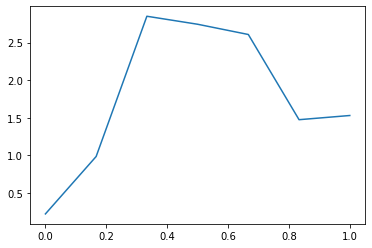

In [31]:
def train():
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
    epochs = 2
    t_init, t_final = f64(0.), f64(1)
    print('start', 'end', t_init, t_final)
    y_init = tf.constant(tf.zeros((num_genes,1), dtype=tf.float64))
    sol_times = tf.reshape(t_inducing, -1)
    odeint = tfp.math.ode.BDF(atol=1e-5, min_step_size_factor=0.2, max_num_steps=50)
    plt.figure()
    plt.plot(t_inducing, m_observed[0,0], label='real')

    basalrates = list()
    decayrates = list()
    lengthscales = list()
    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        with tf.GradientTape() as tape:
            results = odeint.solve(model.call, t_init, y_init,
                                               solution_times=sol_times)
            # print('states', tf.transpose(results.states))
            outputs = tf.transpose(tf.squeeze(results.states))

            loss = loss_object(m_observed[0], outputs)
            print('loss', loss)
            # loss = loss_object(labels, predictions)
        # gradients = tape.gradient(results.states, model.basal_rate)
        # print('basal', gradients)
        trainable_variables = [*model.trainable_variables, *model.kernel.trainable_variables]
        gradients = tape.gradient(loss, trainable_variables)
        print('gradients', gradients)

        optimizer.apply_gradients(zip(gradients, trainable_variables))
        basalrates.append(model.basal_rate.numpy())
        decayrates.append(model.decay_rate.numpy())
        lengthscales.append(model.kernel.lengthscales.numpy())
        plt.plot(t_inducing, outputs[0], label='epoch'+str(epoch))

        # train_loss(loss)
        # train_accuracy(labels, predictions)
    return outputs, (basalrates, decayrates, lengthscales)

outputs, params = train()

In [ ]:
model.kernel.trainable_variables

In [ ]:
plt.figure(figsize=(5, 6))
basal, decay, lengthscale = params
print(lengthscale)
basals = np.array(basal)
decays = np.array(decay)
lengthscales = np.array(lengthscale)
print(lengthscales.shape)
plt.subplot(311)
plt.plot(basals[:,0])
plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
plt.ylim(1, 1.2)

In [62]:
m_observed[0].shape

(5, 7)